In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph_agent_101")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph_agent_101


In [2]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
tool.invoke("테디노트 랭체인 튜토리얼")

[{'title': '랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) - 테디노트',
  'url': 'https://teddylee777.github.io/langchain/langchain-tutorial-01/',
  'content': '태그:\nChatGPT,\nChatOpenAI,\nGPT3.5,\nGPT4,\nlangchain,\nlangchain tutorial,\nOpenAI,\n랭체인,\n랭체인 튜토리얼\n카테고리:\nlangchain\n업데이트: 2023년 09월 28일\n참고\n[Assistants API] Code Interpreter, Retrieval, Functions 활용법\n2024년 02월 13일\n35 분 소요\nOpenAI의 temperature\nmax_tokens\nmodel_name: 적용 가능한 모델 리스트\ngpt-3.5-turbo\ngpt-3.5-turbo-0301\ngpt-3.5-turbo-0613\ngpt-3.5-turbo-16k\ngpt-3.5-turbo-16k-0613\ngpt-3.5-turbo-instruct\ngpt-3.5-turbo-instruct-0914\ngpt-4\ngpt-4-0314\ngpt-4-0613\n🔥 프롬프트 템플릿의 활용\nPromptTemplate\n사용자의 입력 변수를 사용하여 완전한 프롬프트 문자열을 만드는 LangChain 한국어 튜토리얼\n바로가기 👀\n랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1)\n2023년 09월 28일\n5 분 소요\n언어 모델을 활용한 애플리케이션 개발을 돕는 프레임워크인 랭체인(LangChain) 에 대해 깊이 있게 다뤄보고자 합니다.\n ① run()\nrun() 함수로 템플릿 프롬프트 실행\n② apply()\napply() 함수로 여러개의 입력을 한 번에 실행\ntext 키 값으로 결과 뭉치가 반환되었음을 확인할 수 있습니다.\n LLMChain 객체\nLLM

In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

# LLM 초기화
llm = ChatOllama(model="llama3.1:8b")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [19]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

In [20]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [21]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

In [22]:
from langgraph.graph import START, END


def route_tools(state: State):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()


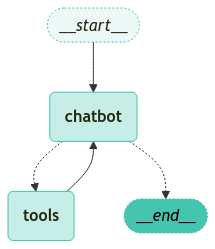

In [23]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)


In [24]:
from pprint import pprint
from langchain_teddynote.messages import display_message_tree

question = "테디노트 YouTube"
events = graph.stream({"messages": [("user", question)]})

for event in events:
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        display_message_tree(value["messages"][-1])


STEP: chatbot

    content: ""
    additional_kwargs: {}
    response_metadata:
        model: "llama3.1:8b"
        created_at: "2025-01-23T13:00:01.187182Z"
        done: True
        done_reason: "stop"
        total_duration: 6338615041
        load_duration: 947148625
        prompt_eval_count: 206
        prompt_eval_duration: 3956000000
        eval_count: 26
        eval_duration: 1431000000
        message:
            role: "assistant"
            content: ""
            images: None
            tool_calls: None
    type: "ai"
    name: None
    id: "run-bc30caa7-5dee-4014-a014-07e65918bc79-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_web_search"
            args: {"query": "테디노트 유튜브"}
            id: "c7e17cec-25f4-440b-a6a3-0b9dd6945c45"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: {"input_tokens": 206, "output_tokens": 26, "total_tokens": 232}

STEP: tools

    content: "[{"title": "강의 - 테디노트", "url": "http